In [52]:
# some prelimenaries
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import numpy as np
import matplotlib.pylab as plt

torch.set_num_threads(16)
torch.manual_seed(0)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

print('Using torch version {}'.format(torch.__version__))
print('Using {} device'.format(device))

Using torch version 2.4.0
Using cuda:0 device


In [53]:
def transpose_from_scratch(lst):
    """
    Меняет местами две оси (размерности) вложенного списка и возвращает результат в виде torch.Tensor.

    Parameters:
    lst: Входной многомерный вложенный список или torch.Tensor
    Returns:
    torch.Tensor: Новый тензор с переставленными осями
    """
    return torch.Tensor([[lst[j][i] for j in range(len(lst))] for i in range(len(lst[0]))])

In [54]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST('/kaggle/working/', train=True, download=True,transform= transform)
test_dataset = MNIST('/kaggle/working/', train=False, download=True,transform= transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [55]:
from torch.distributions import Normal, Bernoulli, Independent, constraints
Bernoulli.support = constraints.interval(0, 1)

In [56]:
d, nh, D = 64, 200, 28 * 28

enc = nn.Sequential(
    nn.Linear(D, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, 2*d)
    )

dec = nn.Sequential(
    nn.Linear(d, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, D)
    )


In [57]:
def loss_vae(x, encoder, decoder):
    """
    Returns:
    1. The average value of the negative ELBO across the minibatch x
    2. The output of the decoder
    """
    # Размер мини-батча
    batch_size = x.size(0)
    
    # Выход энкодера: первый d — mu, следующий d — log(sigma^2)
    encoder_output = encoder(x)
    mu = encoder_output[:, :d]  # Среднее значение для q(z|x, φ)
    log_sigma2 = encoder_output[:, d:]  # Логарифм дисперсии для q(z|x, φ)
    sigma = torch.exp(0.5 * log_sigma2)  # Стандартное отклонение (sigma)
    
    # Определение априорного распределения p(z)
    pz = Independent(Normal(loc=torch.zeros(batch_size, d).to(device),
                            scale=torch.ones(batch_size, d).to(device)),
                     reinterpreted_batch_ndims=1)
    
    # Определение вариационного приближения q(z|x, φ)
    qz_x = Independent(Normal(loc=mu, scale=sigma),
                       reinterpreted_batch_ndims=1)
    
    # Сэмплирование z через трюк репараметризации
    epsilon = torch.randn_like(sigma)  # eps ~ N(0, I)
    z = mu + sigma * epsilon  # z0 = μ(x, φ) + σ(x, φ) * ε
    
    # Выход декодера (p(x|z, θ))
    decoder_output = decoder(z)
    px_z = Independent(Bernoulli(logits=decoder_output),  # Бернулли с параметром logits
                       reinterpreted_batch_ndims=1)
    
    # Вычисление ELBO: L(x, θ, φ)
    log_px_z = px_z.log_prob(x)  # log p(x|z, θ)
    log_pz = pz.log_prob(z)  # log p(z)
    log_qz_x = qz_x.log_prob(z)  # log q(z|x, φ)
    
    # Отрицательная ELBO
    loss = -(log_px_z + log_pz - log_qz_x).mean()  # Среднее по батчу
    
    return loss, decoder_output


In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Пример данных: Перемещаем данные на устройство
x_sample = test_loader.dataset.data[0].float().unsqueeze(0).to(device) / 255.0
x_sample = x_sample.view(-1, D).to(device)

# Отправляем модели на нужное устройство
enc = enc.to(device)
dec = dec.to(device)
with torch.no_grad():
    loss_value, _ = loss_vae(x_sample, enc, dec)

print(f"Loss: {loss_value.item()}")

Loss: 547.6617431640625


In [59]:
from itertools import chain

def train_model(loss, model, batch_size=16, num_epochs=3, learning_rate=1e-3):
    gd = torch.optim.Adam(
        chain(*[x.parameters() for x in model
                if (isinstance(x, nn.Module) or isinstance(x, nn.Parameter))]),
        lr=learning_rate)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(train_loader):
            total = len(train_loader)
            gd.zero_grad()
            batch = batch.view(-1, D).to(device)
            loss_value, _ = loss(batch, *model)
            loss_value.backward()
            train_losses.append(loss_value.item())
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            gd.step()
        test_loss = 0.
        for i, (batch, _) in enumerate(test_loader):
            batch = batch.view(-1, D).to(device)
            batch_loss, _ = loss(batch, *model)
            test_loss += (batch_loss - test_loss) / (i + 1)
        print('\nTest loss after an epoch: {}'.format(test_loss))

    print(f'final train loss: {train_losses[-1]}')
    print(f'final test loss: {test_loss}')

In [60]:
train_model(loss_vae, model=[enc, dec], num_epochs=40)

Train loss: 140.433349609375 Batch 3750 of 3750             
Test loss after an epoch: 131.0825958251953
Train loss: 123.87454223632812 Batch 3750 of 3750           
Test loss after an epoch: 122.99427795410156
Train loss: 116.84882354736328 Batch 3750 of 3750           
Test loss after an epoch: 119.91708374023438
Train loss: 113.02864837646484 Batch 3750 of 3750           
Test loss after an epoch: 117.50572967529297
Train loss: 114.7577896118164 Batch 3750 of 3750            
Test loss after an epoch: 116.57337188720703
Train loss: 122.45573425292969 Batch 3750 of 3750           
Test loss after an epoch: 116.13430786132812
Train loss: 113.26322174072266 Batch 3750 of 3750           
Test loss after an epoch: 115.45610809326172
Train loss: 105.42483520507812 Batch 3750 of 3750           
Test loss after an epoch: 114.88187408447266
Train loss: 125.26739501953125 Batch 3750 of 3750           
Test loss after an epoch: 114.2724609375
Train loss: 106.64263916015625 Batch 3750 of 3750  

In [61]:
def sample_vae(dec, n_samples=50):
    with torch.no_grad():
        samples = torch.sigmoid(dec(torch.randn(n_samples, d).to(device)))
        samples = samples.view(n_samples, 28, 28).cpu().numpy()
    return samples

def plot_samples(samples, h=5, w=10):
    fig, axes = plt.subplots(nrows=h,
                             ncols=w,
                             figsize=(int(1.4 * w), int(1.4 * h)),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap='gray')

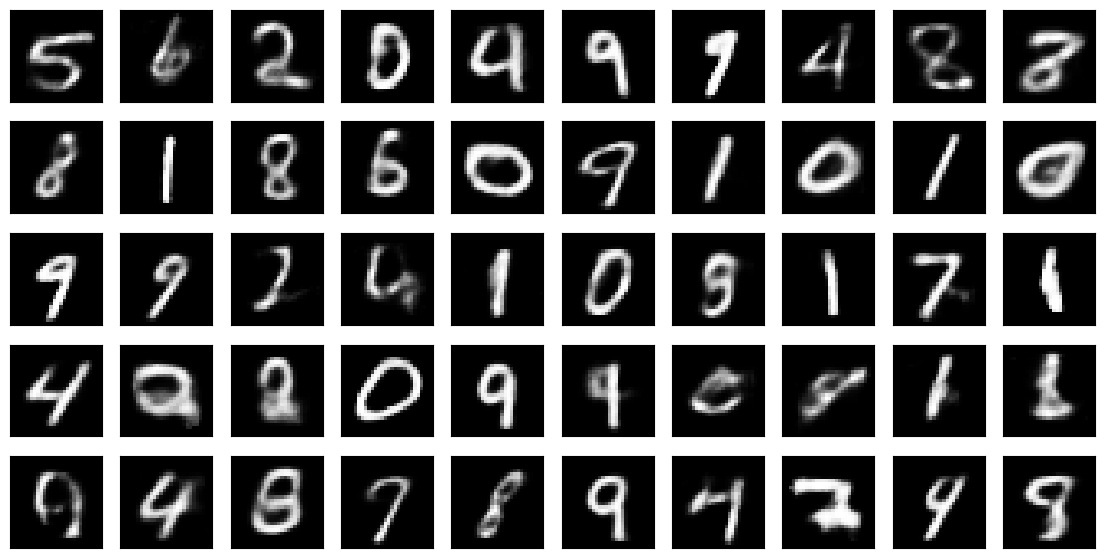

In [62]:
plot_samples(sample_vae(dec=dec))

In [63]:
def plot_reconstructions(loss, model):
    with torch.no_grad():
        batch = (test_loader.dataset.data[:25].float() / 255.)
        batch = batch.view(-1, D).to(device)
        _, rec = loss(batch, *model)
        rec = torch.sigmoid(rec)
        rec = rec.view(-1, 28, 28).cpu().numpy()
        batch = batch.view(-1, 28, 28).cpu().numpy()

        fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                                 subplot_kw={'xticks': [], 'yticks': []})
        for i in range(25):
            if i % 5 == 0:
                axes[i % 5, 2 * (i // 5)].set_title("Orig")
                axes[i % 5, 2 * (i // 5) + 1].set_title("Recon")
            axes[i % 5, 2 * (i // 5)].imshow(batch[i], cmap='gray')
            axes[i % 5, 2 * (i // 5) + 1].imshow(rec[i], cmap='gray')

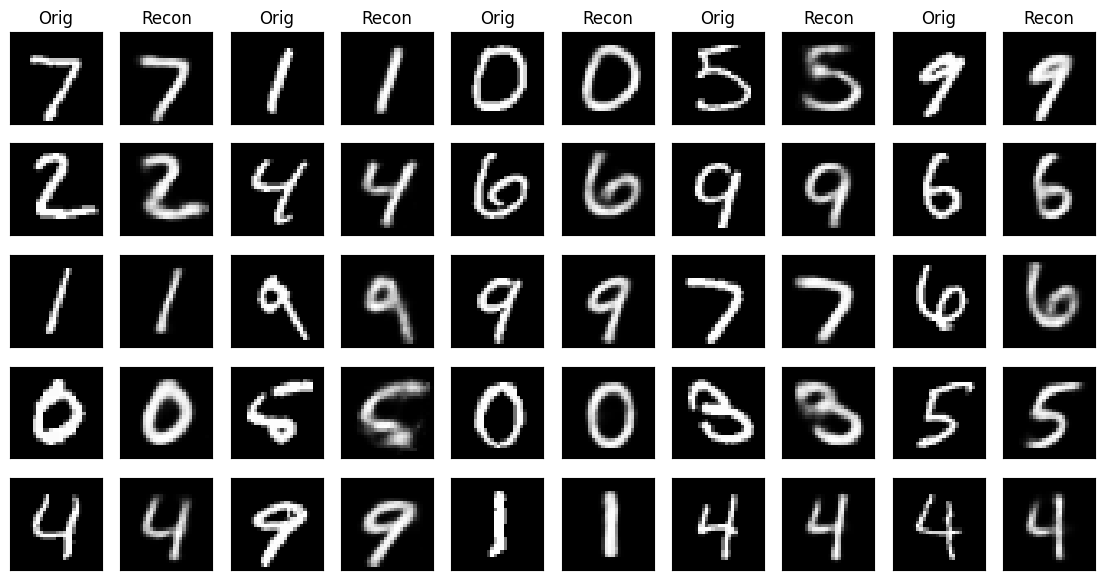

In [64]:
plot_reconstructions(loss_vae, [enc, dec])